In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [2]:
df_medical = pd.read_csv('./data_small/insurance.csv')

numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh.head()


A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0
A_t_medical_groups.sum(axis=0)

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64

In [3]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds
ds_ob = BuildGroupwise_diffseeds(df_medical_mm_oh, 'charges', A_t_medical_groups)
ds_ob.build_all_seeds()
ds_ob.build_df_res()
ds_ob.build_regret_curve()

100%|██████████| 1338/1338 [00:00<00:00, 5297.35it/s]


In [4]:
subgroups_list = [['young', 'middle', 'old'], ['underweight', 'healthyweight', 'overweight',
       'obese'], ['smoker', 'non-smoker'], ['male', 'female'], ['always_on']]

In [5]:
# from bilevel.Groupwise_seedruns import plot_subgroups, plot_regret_curve_with_std

# plot_subgroups(plot_ob, subgroups_list)

young 574


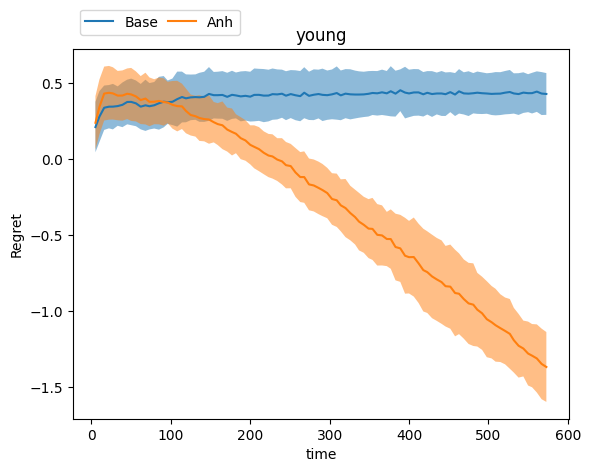

middle 408


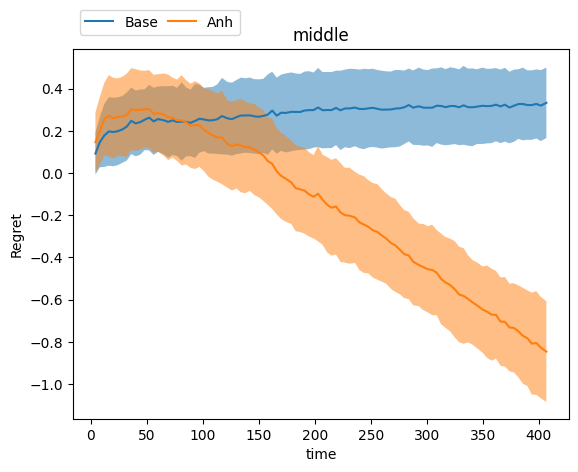

old 356


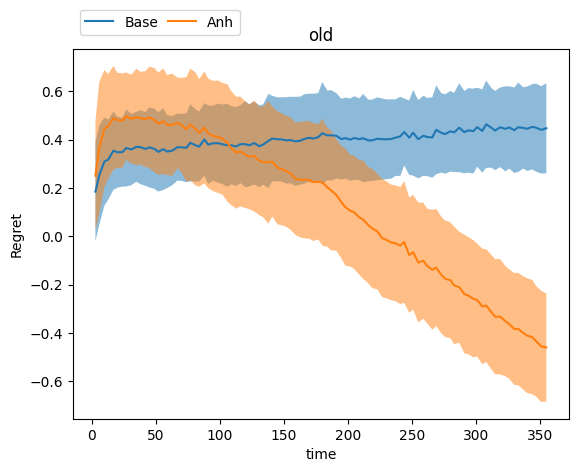

underweight 20


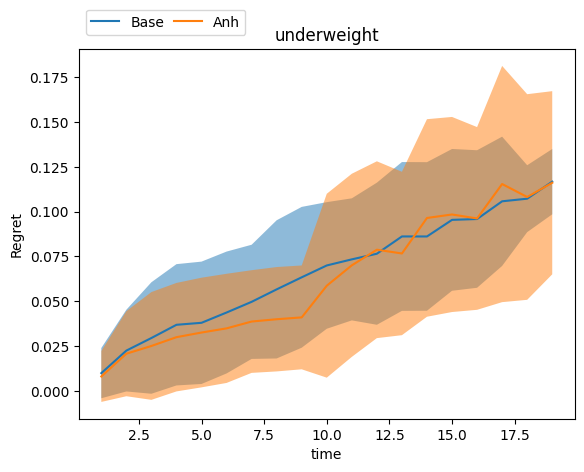

healthyweight 225


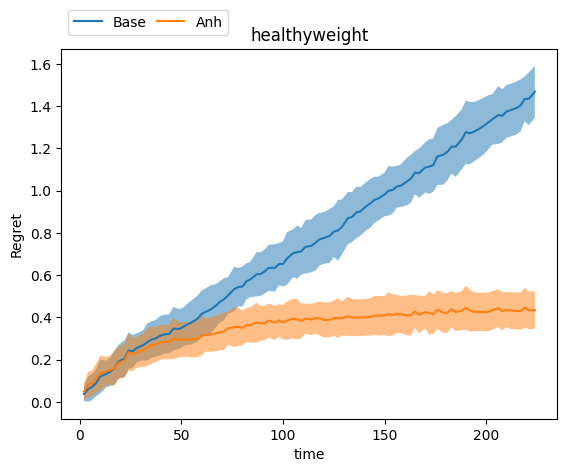

overweight 386


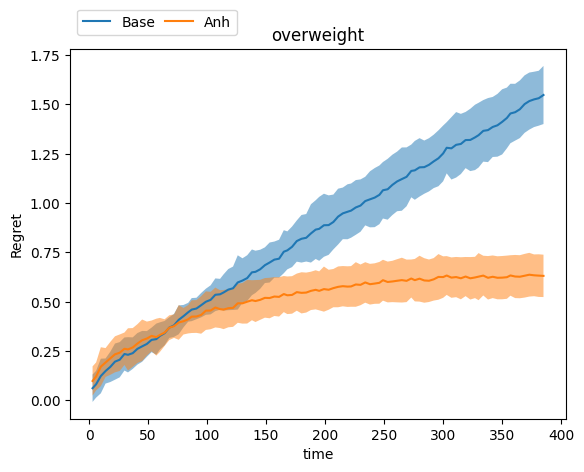

obese 707


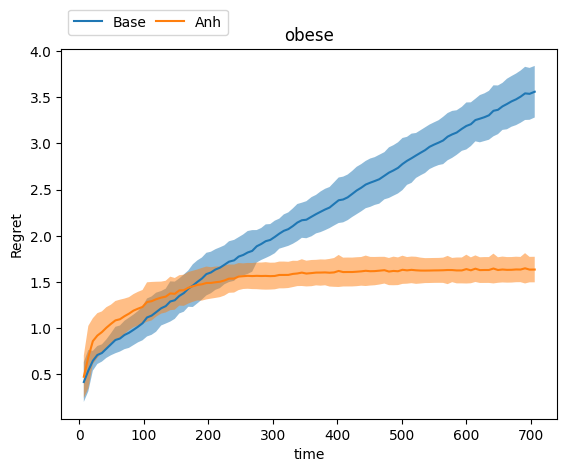

smoker 274


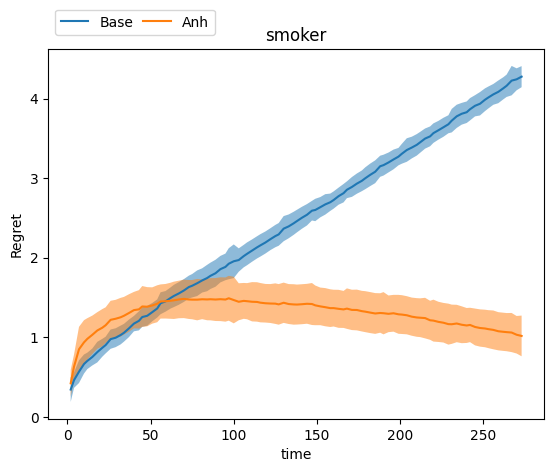

non-smoker 1064


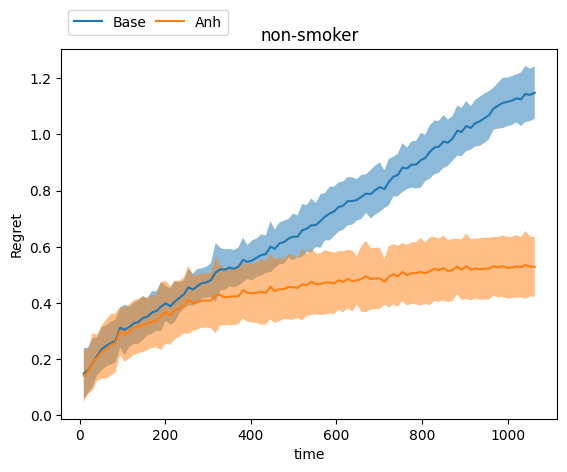

male 676


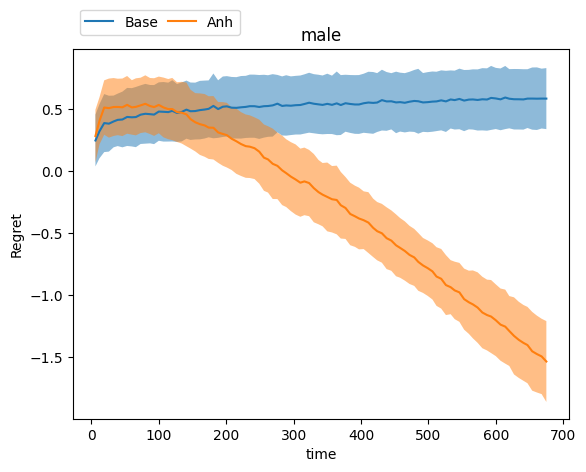

female 662


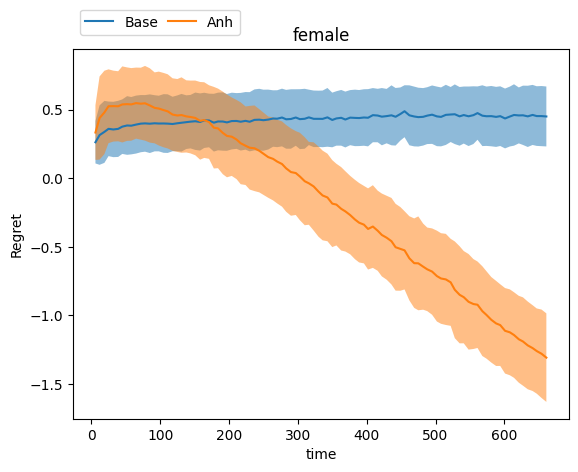

always_on 1338


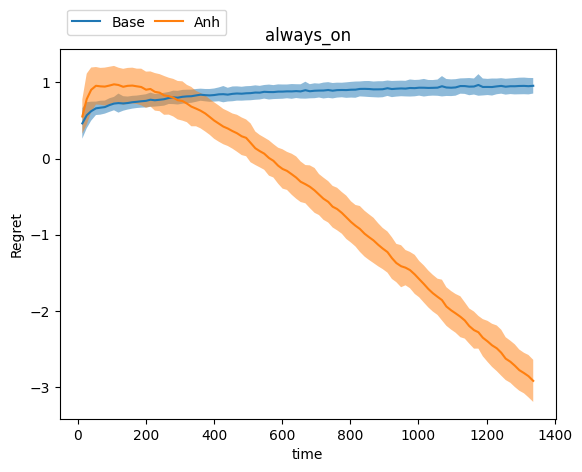

In [6]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std # with random variable in anh loss
plot_regret_curve_with_std(ds_ob, 'medical_costs_plots')

In [8]:
save_ob('medical_gw_clipped.pkl', ds_ob)

In [9]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [10]:
performance_diff(ds_ob)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,5.967306,0.146098,4.174250,0.238525,1.793056,30.048005
middle,3.702279,0.176764,2.523282,0.252460,1.178997,31.845173
old,3.658443,0.197050,2.751704,0.253683,0.906740,24.784848
underweight,0.148706,0.016368,0.148106,0.054454,0.000600,0.403753
healthyweight,2.494085,0.128576,1.459890,0.092272,1.034196,41.465928
overweight,3.390774,0.155504,2.473501,0.113383,0.917273,27.052014
obese,7.294463,0.294631,5.367739,0.145897,1.926725,26.413521
smoker,6.510746,0.142940,3.252237,0.267440,3.258509,50.048169
non-smoker,6.817282,0.098125,6.196998,0.111959,0.620284,9.098698
male,6.866742,0.262068,4.745171,0.345944,2.121571,30.896320
